# Preparation

In [2]:
!pip install scikit-optimize
!pip install optuna
!pip install pmdarima
!pip install statsmodels

  Obtaining dependency information for sqlalchemy>=1.3.0 from https://files.pythonhosted.org/packages/b1/03/d12b7c1d36fd80150c1d52e121614cf9377dac99e5497af8d8f5b2a8db64/SQLAlchemy-2.0.36-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for greenlet!=0.4.17 from https://files.pythonhosted.org/packages/12/da/b9ed5e310bb8b89661b80cbcd4db5a067903bbcd7fc854923f5ebb4144f0/greenlet-3.1.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   -----

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (5, 3)
rand_state = 100510993

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from skopt.space import Integer   # install as: !pip install scikit-optimize
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import warnings
import time
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

# Optuna
import optuna
from sklearn.model_selection import cross_val_score
import logging
# Random Search
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint
# Successive Halving
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV

# Gradient Boosted Trees
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
# Random Forest
from sklearn.ensemble import RandomForestRegressor

In [6]:
df = pd.read_csv('wind_available.csv.gzip', compression='gzip')
df.head(2)

,energy,year,month,day,hour,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
0,402.71,2005,1,2,18,2.534970e+06,2.526864e+06,2.518754e+06,2.510648e+06,2.502537e+06,...,-4.683596,NaN,-4.407196,NaN,-4.131295,-4.669626,-4.528932,-4.388736,-4.248540,-4.107846
1,696.80,2005,1,3,0,NaN,NaN,2.521184e+06,2.513088e+06,NaN,...,-3.397886,-3.257192,-3.115998,-2.975304,-2.834609,-3.396390,-3.254198,-3.112506,-2.970314,NaN


# Explanatory Data Analysis

---



In [31]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

df = pd.read_csv('wind_available.csv.gzip', compression='gzip')

In [15]:
df2 = df.iloc[:,:5]
df3 = df[[col for col in df.columns if col.endswith('.1')]]
df3.head(2)

df_small = pd.concat([df2,df3],axis=1)
df_small.head()

,energy,year,month,day,hour,p54.162.1,p55.162.1,cape.1,p59.162.1,lai_lv.1,...,t2m.1,stl2.1,stl3.1,iews.1,inss.1,stl4.1,fsr.1,flsr.1,u100.1,v100.1
0,402.71,2005,1,2,18,2.534970e+06,9.441719,12.580268,1.400898e+06,2.269523,...,NaN,281.843918,NaN,-0.062834,-0.139944,284.961778,0.341866,NaN,-2.025386,-4.801839
1,696.80,2005,1,3,0,NaN,NaN,3.902914,1.167130e+06,2.269183,...,279.212854,281.517594,282.165020,-0.103328,-0.084481,284.946710,0.341734,-6.343875,-4.058268,NaN
2,1591.15,2005,1,3,6,2.533727e+06,8.200507,NaN,NaN,NaN,...,278.073272,280.878477,282.161701,-0.167291,-0.043463,284.932028,0.342138,NaN,-5.576389,-1.512977
3,1338.62,2005,1,3,12,NaN,7.144935,0.000000,1.090699e+06,2.268398,...,281.512421,280.764032,282.146488,-0.259766,0.077888,284.917926,NaN,-6.408305,-4.922477,1.319376
4,562.50,2005,1,3,18,2.529543e+06,6.861055,0.000000,1.093563e+06,NaN,...,278.137392,281.325434,282.145382,-0.047959,0.030874,284.903437,0.340427,-6.410298,-3.740205,2.018858


In [22]:
df_small[df_small['energy']==df_small['energy'].min()][:3]

,energy,year,month,day,hour,p54.162.1,p55.162.1,cape.1,p59.162.1,lai_lv.1,...,t2m.1,stl2.1,stl3.1,iews.1,inss.1,stl4.1,fsr.1,flsr.1,u100.1,v100.1
13,0.01,2005,1,6,0,2.533813e+06,17.586157,0.871525,1.431865e+06,2.264816,...,281.665142,281.310741,281.903365,NaN,0.119110,284.760289,0.345929,-6.359542,2.412844,5.199954
578,0.01,2005,6,16,12,2.585886e+06,21.970372,NaN,2.139777e+05,3.277246,...,NaN,291.652593,289.979279,-0.011184,-0.007010,286.078566,0.343597,-6.287648,-0.176647,NaN
664,0.01,2005,7,15,0,2.587495e+06,15.465527,2.463004,1.299766e+06,NaN,...,292.621454,298.129203,293.118591,0.020302,0.009751,288.769792,0.343580,-6.373726,2.321819,-0.427832


In [42]:
df_small.head(3)

,energy,year,month,day,hour,p54.162.1,p55.162.1,cape.1,p59.162.1,lai_lv.1,...,stl2.1,stl3.1,iews.1,inss.1,stl4.1,fsr.1,flsr.1,u100.1,v100.1,yearmonth
0,402.71,2005,1,2,18,2.534970e+06,9.441719,12.580268,1.400898e+06,2.269523,...,281.843918,NaN,-0.062834,-0.139944,284.961778,0.341866,NaN,-2.025386,-4.801839,2005-1
1,696.80,2005,1,3,0,NaN,NaN,3.902914,1.167130e+06,2.269183,...,281.517594,282.165020,-0.103328,-0.084481,284.946710,0.341734,-6.343875,-4.058268,NaN,2005-1
2,1591.15,2005,1,3,6,2.533727e+06,8.200507,NaN,NaN,NaN,...,280.878477,282.161701,-0.167291,-0.043463,284.932028,0.342138,NaN,-5.576389,-1.512977,2005-1


<BarContainer object of 48 artists>

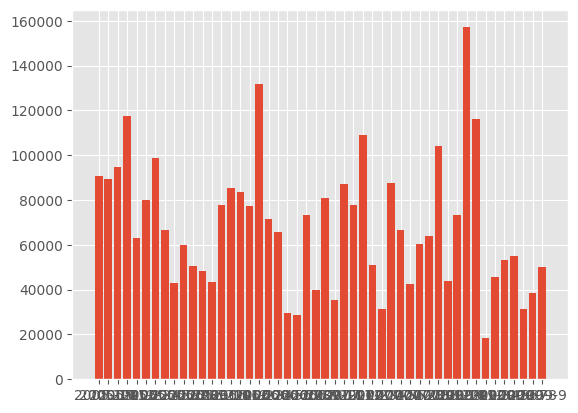

In [49]:
df_small['yearmonth'] = df_small['year'].astype(str) + '-' + df_small['month'].astype(str) 
xvxvxv = df_small.groupby('yearmonth')['energy'].sum().reset_index()

plt.bar(xvxvxv['yearmonth'],xvxvxv['energy'])

In [47]:
df_small['yearmonth'].unique()

array(['2005-1', '2005-2', '2005-3', '2005-4', '2005-5', '2005-6',
       '2005-7', '2005-8', '2005-9', '2005-10', '2005-11', '2005-12',
       '2006-1', '2006-2', '2006-3', '2006-4', '2006-5', '2006-6',
       '2006-7', '2006-8', '2006-9', '2006-10', '2006-11', '2006-12',
       '2007-1', '2007-2', '2007-3', '2007-4', '2007-5', '2007-6',
       '2007-7', '2007-8', '2007-9', '2007-10', '2007-11', '2007-12',
       '2008-1', '2008-2', '2009-3', '2009-4', '2009-5', '2009-6',
       '2009-7', '2009-8', '2009-9', '2009-10', '2009-11', '2009-12'],
      dtype=object)

<BarContainer object of 12 artists>

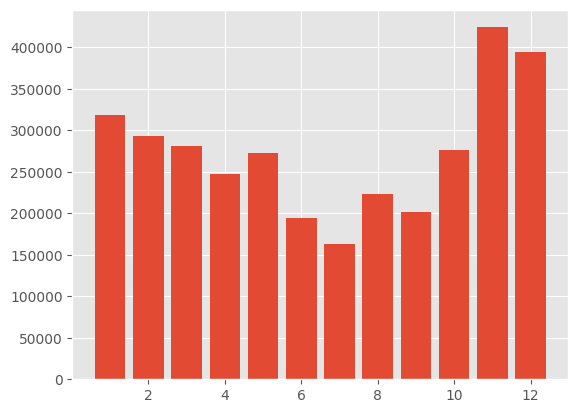

In [36]:
energy_per_month = df_small.groupby('month')['energy'].sum().reset_index()


plt.bar(energy_per_month['month'],energy_per_month['energy'])

In [47]:
print(df.shape)

(4748, 555)


There are 4748 rows (instances) and 555 columns (features) in the dataset.

In [48]:
non_numerical_column_names = df.select_dtypes(exclude=['number']).columns.tolist()
non_numerical_column_names

[]

In [49]:
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
constant_columns

[]

There are no categorical variables, or variables with constant values in the dataset. However, except for the first 5 columns which correspond to the target variable and a time stamp, NA values are very common in the dataset.

In [50]:
# number of NAs per column
na_count_per_column = df.isna().sum()
na_count_per_column

energy       0
year         0
month        0
day          0
hour         0
          ... 
v100.21    261
v100.22    387
v100.23    569
v100.24    579
v100.25    436
Length: 555, dtype: int64

**Target variable - Energy**

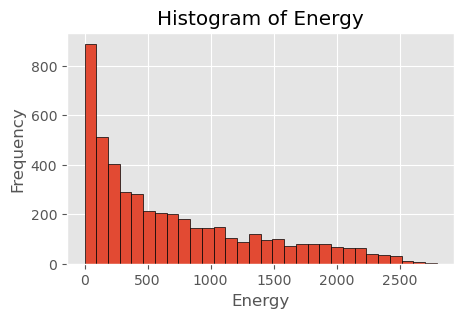

In [51]:
plt.hist(df['energy'], bins=30, edgecolor='black')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Histogram of Energy')
plt.show()

There are many instances with low to moderate production of energy. Overall the histogram suggests a right-skewed distribution.

In [52]:
df_energy = df.iloc[:,:5]
df_energy["Year-Month"] = df_energy['year'].astype(str) + "-" + df_energy['month'].astype(str)

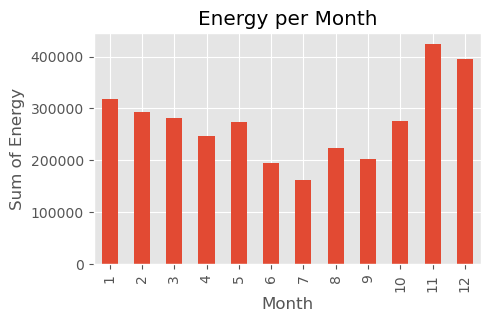

In [53]:
# per month
energy_per_month = df_energy.groupby('month')['energy'].sum()
energy_per_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Sum of Energy')
plt.title('Energy per Month')
plt.show()

There is a clear pattern for energy production when viewed per month. Towards winter/the end of the year production rises, while in summer it is significantly lower.

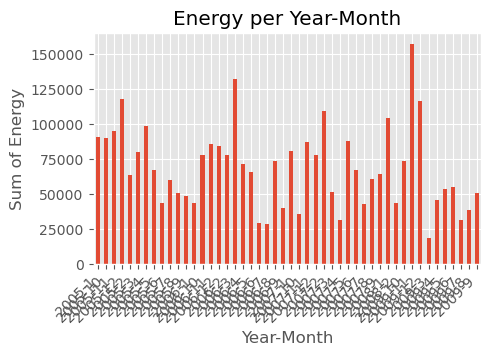

In [54]:
# per year-month
year_monthly_energy = df_energy.groupby('Year-Month')['energy'].sum()
ax = year_monthly_energy.plot(kind='bar')
plt.xlabel('Year-Month')
plt.ylabel('Sum of Energy')
plt.title('Energy per Year-Month')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

Variation per year-month is very pronounced indicating seasonal trends.

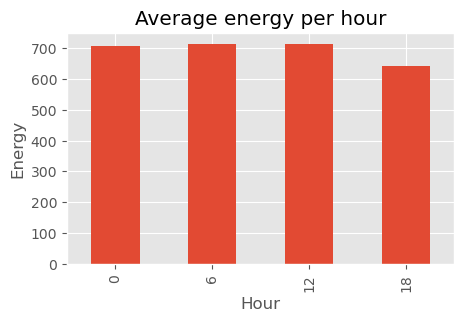

In [55]:
# per hour
avg_energy_per_hour = df_energy.groupby('hour')['energy'].mean()
avg_energy_per_hour.plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Energy')
plt.title('Average energy per hour')
plt.show()

Energy production is very constant across different hours with a slight decrease at the end of the day.

# Model Evaluation

**Outer Evaluation**<br>
For the outer evaluation of our models we will use a hold-out validation. As the data is of temporal order, five years in total, we use different years for the training and testing partitions. The data of the first four years will be used as the training partition. The data of of the last year (2009) will be used as the testing partition. The testing partition accounts for 921 instances, 19.4% of the whole dataset.


In [56]:
df['year'].unique()
df['year'].value_counts()

year
2006    1272
2005    1256
2007    1121
2009     921
2008     178
Name: count, dtype: int64

In [57]:
def train_test_split(df, year = 2009):
    test = df[df['year'] == year]
    train = df[df['year'] != year]

    X_train = train.drop('energy', axis=1)
    y_train = train['energy']
    X_test = test.drop('energy', axis=1)
    y_test = test['energy']
    return (X_train, X_test, y_train, y_test)

# split for different datasets
X_train, X_test, y_train, y_test  = train_test_split(df, year = 2009)

**Inner Evaluation**<br>
   For the inner evaluation of the models and comparing their performance, a 5-fold crossvalidation will be used. This method provides a more robust estimation than holdout as well as a better generalization. Additionally, it has a more efficient use of data as each instance is used both for training or testing in the different folds.

The data will not be shuffled in order to retain the temporal order of the data. From the crossvalidation, we compute the (negative) mean squared error to compare different models. For easier readability, we divide the score by factor 1000 when displaying it in a table.

In order to save computation time, we refrain from doing repeated crossvalidation at the cost of less stable results.

In [58]:
inner_eval = KFold(n_splits=5, shuffle = False)

# Base Model: Regression Tree

First, we build a Regression Tree which will be used as a base model in order to test out effects of different datasets and imputation method used.<br>
For the model we choose the exhaustive method GridSearch in order to guarantee that the same (all) of the given parameters are used for all models and the optimal hyperparameters are (always) found.

In [59]:
def regression_tree_GridSearch(X_train, X_test, y_train, y_test):
    search_space = {
    'max_depth': np.arange(4,21,2),
    'min_samples_split': np.arange(80,181,10)
    }

    regr_default = DecisionTreeRegressor(random_state = rand_state)
    #  GridSearch
    regr_hpo = GridSearchCV(
      regr_default,
      search_space,
      scoring='neg_mean_squared_error',
      cv=inner_eval,
      n_jobs=-1,
      verbose=0
    )

    regr_hpo.fit(X_train, y_train)

    print("Best parameters:", regr_hpo.best_params_)
    return regr_hpo

### Impute data

Even though the decision tree should be able to handle missign values, we use mean-imputation to compare the different datasets as we expect this to give us more reliable results. Later on, other imputation methods (and no imputation at all) will be tested and compared.

In [60]:
def train_test_split_mean_imput(df, year = 2009):
    test = df[df['year'] == year]
    train = df[df['year'] != year]

    test = test.fillna(test.mean())
    train = train.fillna(train.mean())

    X_train = train.drop('energy', axis=1)
    y_train = train['energy']

    X_test = test.drop('energy', axis=1)
    y_test = test['energy']
    return (X_train, X_test, y_train, y_test)

# Feature Selection

In the following, we train our base model with different subsets of the original dataset. Afterwards, we compare the inner evaluation scores of the models.

**All variables**<br>
In the first model we consider all available variables from all the different stations.

In [61]:
# all variables
df_all_variables = df.copy()

**Sotavento**

In the next model, only the variables that are obtained from the Sotavento station (.13) itself are considered. This leads to the smallest of all tested subsets.

In [62]:
# only Sotavento
sotavento_col = [col for col in df.columns if '.13' in col]
df_sotavento = df.iloc[:, :5].copy()
df_sotavento = pd.concat([df_sotavento, df[sotavento_col]], axis=1)

**Sotavento + Edge Station**

As a compromise between using all variables and using only the ones from Sotavento station, the next model considers the variables from Sotavento stations (.13) as well from the four stations on the far edges (.1, .5, .21, .25). The idea is that by considering all stations, a lot of redundant information is fed to the model, whereas by only considering Sotavento data, too much information is lost.

In [63]:
# Sotavento + edge stations
stations = [1,5,13,21,25]
columns_to_keep = []

for col in df.columns:
    if any(col.endswith(f'.{station}') for station in stations):
        columns_to_keep.append(col)

df_edge_stations = df.iloc[:, :5].copy()
df_edge_stations = pd.concat([df_edge_stations, df[columns_to_keep]], axis=1)

**Wind-related**

The final subset consists only of the wind-related variables (from all stations) as these are expected to have the greatest influence on the target.

In [64]:
# wind related columns
wind_related = ['u10', 'v10', 'u100', 'v100', 'iews', 'inss', 'u10n', 'v10n']
columns_to_keep = [col for col in df.columns if any(var in col for var in wind_related)]

df_wind = df.iloc[:, :5].copy()
df_wind = pd.concat([df_wind, df[columns_to_keep]], axis=1)

In [65]:
# list of all datasets
datasets_list = [df_all_variables, df_sotavento, df_edge_stations, df_wind]

### Model comparison

Comparison by inner evaluation as defined before, using (negative) mean squared error.

In [66]:
warnings.filterwarnings("ignore", category=UserWarning, module="skopt.optimizer.optimizer")
warnings.filterwarnings("ignore", category=DeprecationWarning)

datasets_names = ["all_variables", "sotavento", "edge_stations", "wind"]
best_parameters = []
best_score = []
running_time = []

for dataset in datasets_list:
    X_train, X_test, y_train, y_test  = train_test_split_mean_imput(dataset)

    t0 = time.time()
    regr_result = regression_tree_GridSearch(X_train, X_test, y_train, y_test)
    running_time.append(round(time.time()-t0, 4))

    # save results
    best_parameters.append(regr_result.best_params_)
    best_score.append(regr_result.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_split': 150}
Best parameters: {'max_depth': 14, 'min_samples_split': 100}
Best parameters: {'max_depth': 14, 'min_samples_split': 170}
Best parameters: {'max_depth': 8, 'min_samples_split': 170}


In [67]:
best_score = [round(x/1000,2) for x in best_score]
scores = pd.DataFrame({'Dataset': datasets_names, 'Best score': best_score, 'Execution time': running_time}).set_index('Dataset').T
scores

Dataset,all_variables,sotavento,edge_stations,wind
Best score,-174.3500,-182.3900,-176.1600,-181.9100
Execution time,123.2516,5.4011,26.4066,45.7648


As was expected, when considering all variables, the inner evaluation shows the lowest error among the compared datasets. However, the execution time is very high in comparison to the reduced datasets. <br>
While reducing the execution time by a huge factor, using only the variables of the Sotavento station, model performance is worse. Considering only wind-related variables shows a performance similar to the one only considering Sotavento. <br>
The model based on the dataset containing data from Sotavento as well as the edge stations offers a very good compromise between performance (which is only very slightly below the performance using all variables) and execution time. As execution time will be of greater significance for the more complex models later on, we will continue with the dataset **"edge_stations"** instead of using all available variables.

# Imputation

---

In the following the effects of using different imputation methods for our base model are compared.

First, we take a look at the missing data in our dataset. It is important to try and understand why there are missing data, due to chance or certain patterns.

From the datagram below it is clear the number of N/A is quite large for all features except the target and timestamp.

## Missing Data

In [28]:
df.isnull().sum().sort_values(ascending=False).index[:10]


Index(['lai_hv.13', 'fsr.3', 'v10n.24', 'stl3.20', 'lai_hv.19', 'lai_lv.3',
       'inss.11', 'p55.162.25', 'v10.2', 't2m.4'],
      dtype='object')

<Axes: >

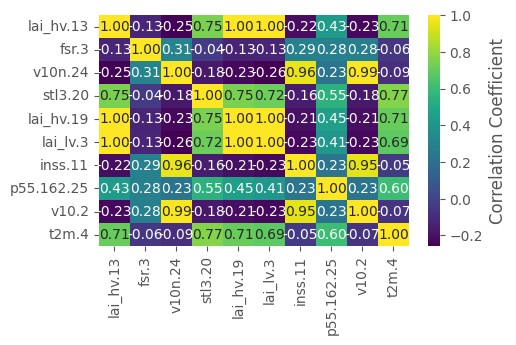

In [34]:
corr = df[df.isnull().sum().sort_values(ascending=False).index[:10]].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Correlation Coefficient'})


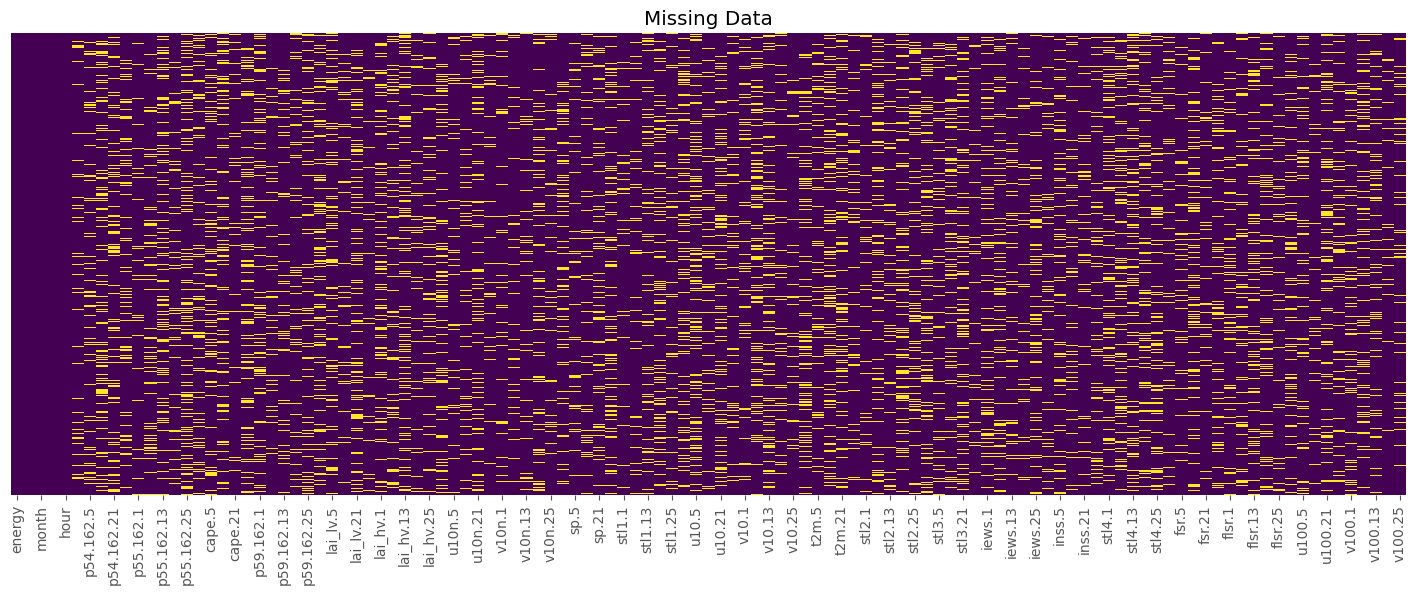

In [68]:
missing = df_edge_stations.isnull()
plt.figure(figsize=(18, 6))
sns.heatmap(missing, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data')
plt.show()

In [69]:
# Checking the top 10 columns with the most missing values
missing_values_sum = df_edge_stations.isnull().sum()
sorted_missing_values = missing_values_sum.sort_values(ascending=False)
top_missing_features = sorted_missing_values.head(10)
print(top_missing_features)

lai_hv.13     964
p55.162.25    938
lai_lv.1      927
stl3.1        921
stl4.5        917
v10.5         910
p55.162.13    902
u10.5         902
p59.162.1     892
stl2.21       876
dtype: int64


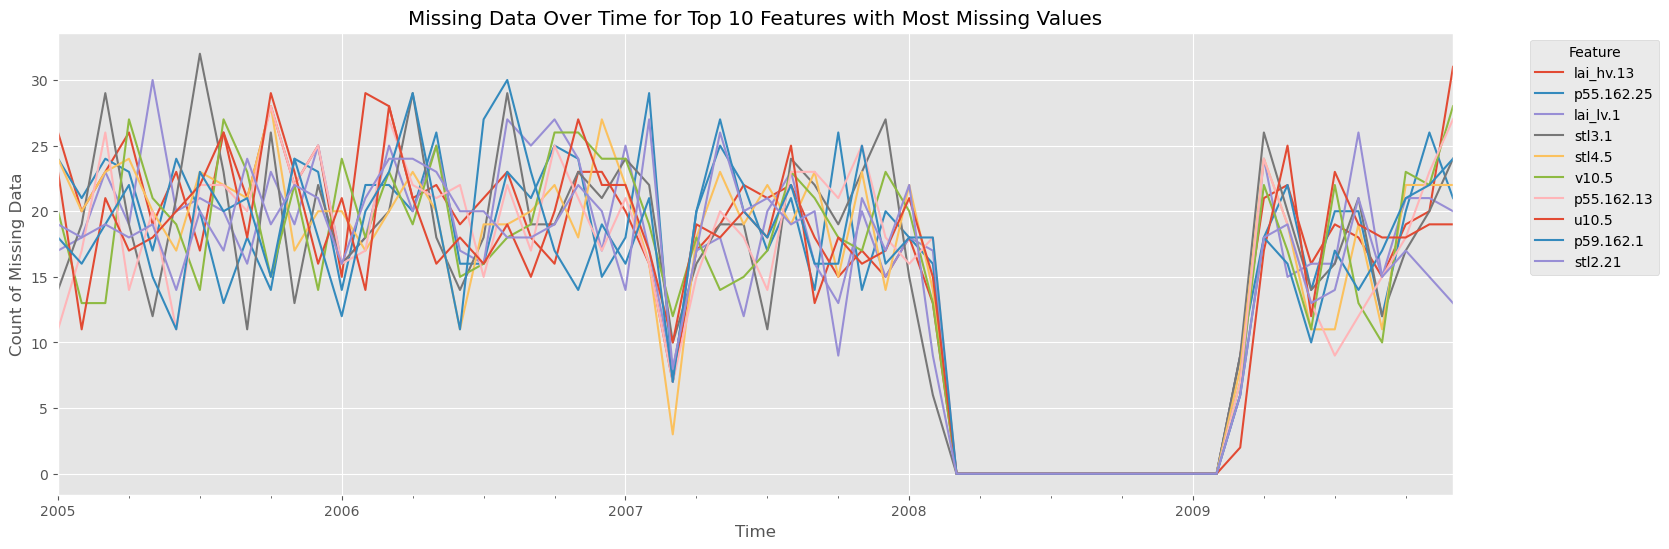

In [70]:
#Checking if there is any correclation in time between those 10
df_missing = df_edge_stations.copy() #new df for analysis
df_missing['datetime'] = pd.to_datetime(df_missing[['year', 'month', 'day', 'hour']])
df_missing.set_index('datetime', inplace=True)

columns_to_analyze = [
    'lai_hv.13', 'p55.162.25', 'lai_lv.1', 'stl3.1', 'stl4.5',
    'v10.5', 'p55.162.13', 'u10.5', 'p59.162.1', 'stl2.21'
]

df_missing = df_missing[columns_to_analyze]

# counting the missing values per month
missing_data_by_month = df_missing.isnull().resample('M').sum()

missing_data_by_month.plot(figsize=(18, 6), title='Missing Data Over Time for Top 10 Features with Most Missing Values')
plt.xlabel('Time')
plt.ylabel('Count of Missing Data')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



* All features show some fluctuation in the count of missing values over time. This could be indicative of external factors affecting data availability, which makes sense as we are dealing with wind.
* There are points in time where certain features experience a sudden increase in missing values notably around late 2008 for several features. might be the case of a proces cease or so.
* Some features show more variability in the count of missing values such as lai_hv.13 and lai_lv.1 which are both related to the lai_lv: Leaf area index.




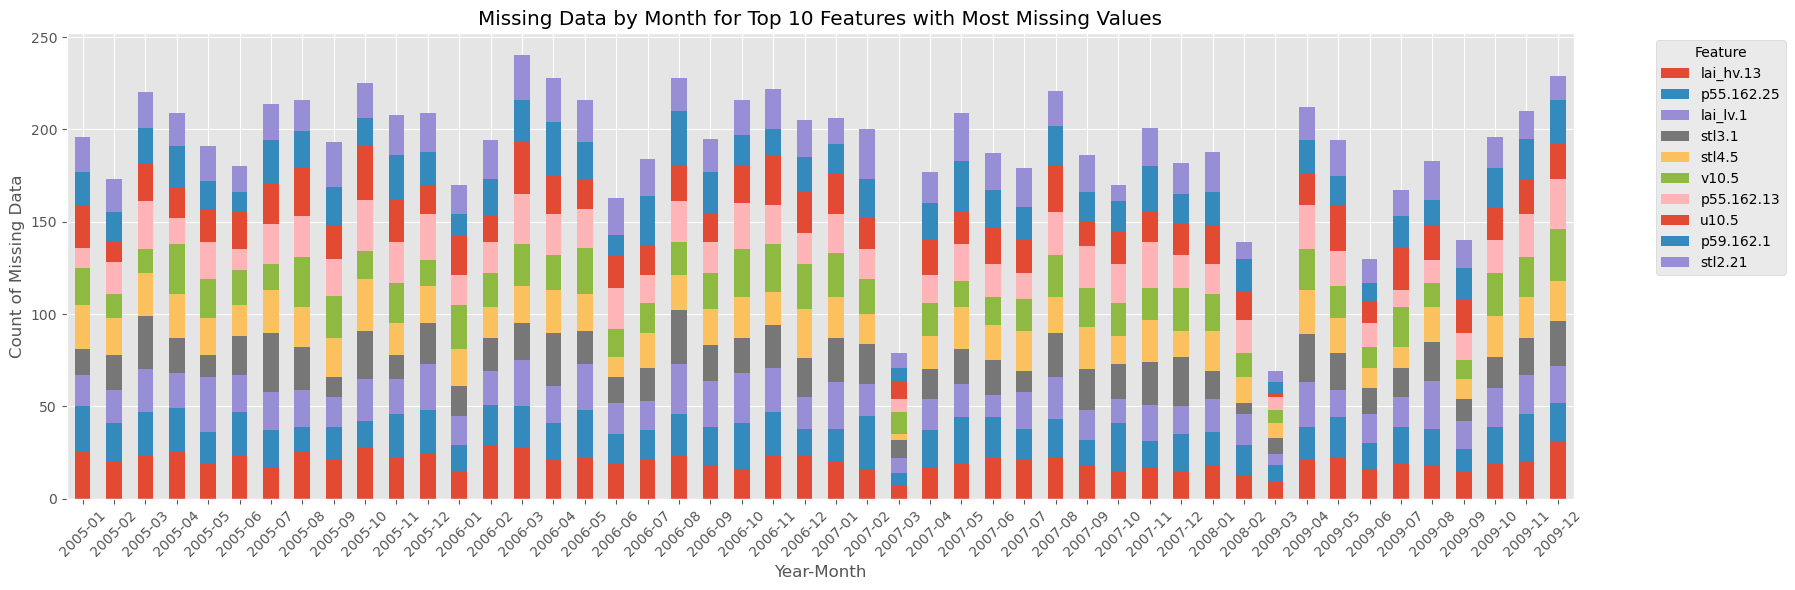

In [71]:
df_missing = df_edge_stations.copy() # creating a datetime index
df_missing['datetime'] = pd.to_datetime(df_missing[['year', 'month', 'day', 'hour']])
df_missing.set_index('datetime', inplace=True)

columns_to_analyze = [
    'lai_hv.13', 'p55.162.25', 'lai_lv.1', 'stl3.1', 'stl4.5',
    'v10.5', 'p55.162.13', 'u10.5', 'p59.162.1', 'stl2.21'
]

df_missing = df_missing[columns_to_analyze] #drop the non-missing columns.
df_missing['year_month'] = df_missing.index.to_period('M')
missing_data_by_month = df_missing.groupby('year_month').apply(lambda x: x.isnull().sum())
missing_data_by_month = missing_data_by_month.drop(columns='year_month')

# plot the missing data over time for the selected components
missing_data_by_month.plot(kind='bar', stacked=True, figsize=(18, 6), title='Missing Data by Month for Top 10 Features with Most Missing Values')
plt.xlabel('Year-Month')
plt.ylabel('Count of Missing Data')
# adjusting the layout
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


* There appears to be a cyclical pattern in missing data with peaks and troughs occurring at regular intervals, hence the seasonality due to the data type.
* Some months consistently have higher missing data across all features in cumulative such as months during midyear.
* Certain features have distinct peaks such as lai_hv.13 peaking at certain points distinct from other features.

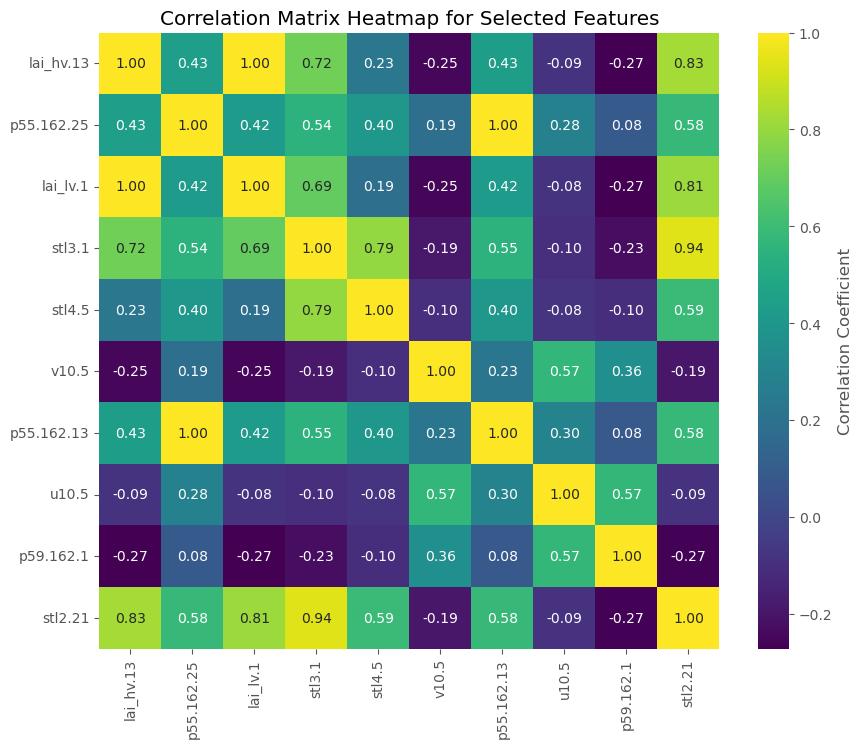

In [72]:
#Checking if there is any correclation in time between those 10
columns_to_analyze = [
    'lai_hv.13', 'p55.162.25', 'lai_lv.1', 'stl3.1', 'stl4.5',
    'v10.5', 'p55.162.13', 'u10.5', 'p59.162.1', 'stl2.21'
]
correlation_matrix = df_edge_stations[columns_to_analyze].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix Heatmap for Selected Features')
plt.show()

* It is obvious that the lai_hv.13 and lai_lv.1 components are greatly related, hence as they are related with the same component if one is missing the other one will be missing as well.
* stl3.1 and stl2.21 are also highly correlated with a coefficient of 0.94 which makes sense as they are related with the soil temperature.

Overall, the patterns suggest the presence of the obvious temporal dynamics influencing the occurrence of missing data, which could be related to seasonal effects, maintenance periods, or other time-related factors.

## Imputation methods

Next, using our base modell, we try out different imputation methods. Following imputation methods are compared:
- no imputation
- univariate imputation: mean and median
- Multiple Imputation by Chained Equations (MICE)
- KNN-imputation

We update our function for splitting data into train and test by adding different imputation methods (mean, median, MICE, KNN). Imputation is applied seperately to the training and testing partitions to avoid data leakage.

In [73]:
def train_test_split_impute(df, impute_method, year):
    train_raw = df[df['year'] != year]
    test_raw = df[df['year'] == year]

    if impute_method == 'none':
        train = train_raw
        test = test_raw
    elif impute_method == 'mean':
        train = train_raw.fillna(train_raw.mean())
        test = test_raw.fillna(test_raw.mean())
    elif impute_method == 'median':
        train = train_raw.fillna(train_raw.median())
        test = test_raw.fillna(test_raw.median())
    elif impute_method == 'KNN':
        train = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(train_raw),
                                 columns=train_raw.columns,
                                 index=train_raw.index)
        test = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(test_raw),
                                 columns=test_raw.columns,
                                 index=test_raw.index)
    elif impute_method == 'MICE':
        train = pd.DataFrame(IterativeImputer(max_iter=50, random_state= rand_state).fit_transform(train_raw),
                                       columns=train_raw.columns,
                                       index=train_raw.index)
        test = pd.DataFrame(IterativeImputer(max_iter=50, random_state= rand_state).fit_transform(test_raw),
                                           columns=test_raw.columns,
                                           index=test_raw.index)
    else:
        raise ValueError('Invalid imputation method')


    X_train = train.drop('energy', axis=1)
    y_train = train['energy']

    X_test = test.drop('energy', axis=1)
    y_test = test['energy']

    print(f'Data split, imputation method: "{impute_method}"')
    return (X_train, X_test, y_train, y_test)

### Comparison of imputation methods


In [74]:
impute_methods = ['none', 'mean', 'median', 'MICE', 'KNN']

best_parameters = []
best_score = []
running_time = []

for method in impute_methods:
    t0 = time.time()
    X_train, X_test, y_train, y_test  = train_test_split_impute(df_edge_stations, method, year = 2009)
    regr_result = regression_tree_GridSearch(X_train, X_test, y_train, y_test)
    running_time.append(round(time.time()-t0, 4))

    # save results
    best_parameters.append(regr_result.best_params_)
    best_score.append(regr_result.best_score_)

Data split, imputation method: "none"
Best parameters: {'max_depth': 4, 'min_samples_split': 80}
Data split, imputation method: "mean"
Best parameters: {'max_depth': 14, 'min_samples_split': 170}
Data split, imputation method: "median"
Best parameters: {'max_depth': 10, 'min_samples_split': 110}


C:\Users\morit\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Data split, imputation method: "MICE"
Best parameters: {'max_depth': 6, 'min_samples_split': 80}
Data split, imputation method: "KNN"
Best parameters: {'max_depth': 14, 'min_samples_split': 160}


*Note: when running in Google Colab, it was not possible to train the Regression Tree for the dataset containing NA-values. In Jupyter, however, it was possible.*

In [75]:
best_score = [round(x/1000,2) for x in best_score]
scores = pd.DataFrame({'Imputation Method': impute_methods, 'Best score': best_score, 'Execution time': running_time}).set_index('Imputation Method').T
scores

Imputation Method,none,mean,median,MICE,KNN
Best score,-296.5200,-176.1600,-176.5400,-163.4800,-178.2800
Execution time,13.1785,26.2175,26.5796,199.6036,32.4141


- Even though the early stopping criterion was not reached, the **MICE imputation** shows the best performance. Since imputation only needs to be done once, we don't care too much about the higher execution time, and therefore, continue with MICE imputation.

- As an increase in the maximum number of iteration for MICE did not lead to a significant increase in performance, we kept it at 50.

- Using no imputation at all acheives by far the worst score.

- It is also noteworthy that the KNN imputation actually leads to a lower performance (by inner evaluation) than the univariate methods.

In [76]:
# Impute using MICE
X_train, X_test, y_train, y_test  = train_test_split_impute(df_edge_stations, impute_method = 'MICE', year = 2009)

C:\Users\morit\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Data split, imputation method: "MICE"


# HPO comparison

As of now we used an exhaustive method (GridSearch) to find optimal hyperparameters within the parameter space. Now, more advanced  hyperparameter optimization methods will be compared based on our base model. The search space will be expanded for this, as we expect the new methods to be more performant.

Following methods will be compared:
* Bayesian optimization: Skopt
* Bayesian optimization: Optuna
* Random Search
* Successive Halving

In [77]:
running_time = []

# define search space parameters
max_depth_lower = 2
max_depth_upper = 21
min_samples_split_lower = 10
min_samples_split_upper = 201

# budget
budg = 100

rand_state = 100510993

## Skopt Bayes

In [78]:
def regression_tree_bayes(X_train, X_test, y_train, y_test):
    search_space = {
      'max_depth': np.arange(max_depth_lower, max_depth_upper),
      'min_samples_split': np.arange(min_samples_split_lower, min_samples_split_upper, step = 5)
    }
    regr_default = DecisionTreeRegressor(random_state = rand_state)

    np.int = int    # np.int causes problems with BayesSearch
    budget = budg
    regr_hpo = BayesSearchCV(
        regr_default,
        search_space,
        n_iter=budg,
        scoring='neg_mean_squared_error',
        cv=inner_eval,
        random_state= rand_state,
        verbose=0,
        n_jobs = -1
    )

    regr_hpo.fit(X_train, y_train)
    predictions_y_test = regr_hpo.predict(X_test)

    print("Best parameters:", regr_hpo.best_params_)
    return regr_hpo, predictions_y_test

In [79]:
t0 = time.time()
regr_result, predictions = regression_tree_bayes(X_train, X_test, y_train, y_test)
running_time_skopt = round(time.time()-t0,2)

best_score_skopt = regr_result.best_score_
print(best_score_skopt)

Best parameters: OrderedDict([('max_depth', 9), ('min_samples_split', 125)])
-165928.42206697166


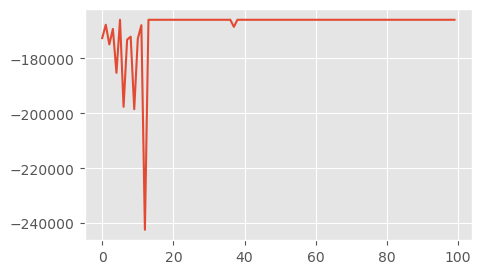

In [80]:
scores = regr_result.cv_results_['mean_test_score']
plt.plot(range(0,len(scores)), scores)

Visualizing the scores achieved in each iteration, it can be seen that it converges to the maximum value after around 15 iterations.

## Optuna

In [81]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    # hyperparameters
    max_depth = trial.suggest_int('max_depth', max_depth_lower, max_depth_upper, step =2)
    min_samples_split = trial.suggest_int('min_samples_split', min_samples_split_lower, min_samples_split_upper, step = 5)
    #criterion = trial.suggest_categorical('criterion', ['poisson', 'absolute_error', 'squared_error', 'friedman_mse']) # criterion for inner evaluation

    params = {'max_depth': max_depth, 'min_samples_split': min_samples_split}#, 'criterion': criterion}
    regr = DecisionTreeRegressor(random_state = rand_state, **params)

    inner_score = cross_val_score(regr, X_train, y_train, cv = inner_eval, scoring = 'neg_mean_squared_error').mean()
    return inner_score

# Optimization for best params
def get_best_params_optuna():
    sampler = optuna.samplers.TPESampler(seed = rand_state)
    study = optuna.create_study(direction = 'maximize', sampler = sampler)
    budget = budg

    # Suppress warnings during optimization
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        study.optimize(objective, n_trials=budget)

    # Best hyperparameters
    return study.best_params, study.trials

In [82]:
def optuna_run():
    best_params, trials = get_best_params_optuna()
    scores = [trial.value for trial in trials]
    regr_hpo = DecisionTreeRegressor(random_state = rand_state, **best_params)
    regr_hpo.fit(X_train, y_train)
    predictions_y_test = regr_hpo.predict(X_test)

    print("Best parameters:", best_params)
    return regr_hpo, predictions_y_test, scores

In [83]:
t0 = time.time()
regr_result, predictions, scores = optuna_run()
running_time_optuna = round(time.time()-t0,2)

best_score_optuna = max(scores)
print(best_score_optuna)

Best parameters: {'max_depth': 6, 'min_samples_split': 70}
-163255.6618288558


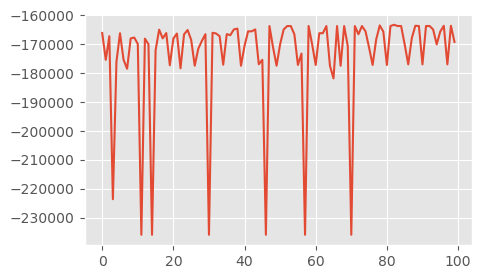

In [84]:
plt.plot(range(0,len(scores)), scores)

Using Optuna, convergence is much slower and even at the end of the set budget there is quite a lot of fluctuation.

## Random Search

In [85]:
def regression_tree_random_search(X_train, X_test, y_train, y_test):
    search_space = {
        'max_depth': np.arange(max_depth_lower, max_depth_upper),
        'min_samples_split': np.arange(min_samples_split_lower, min_samples_split_upper, step = 5)
    }

    regr_default = DecisionTreeRegressor(random_state=rand_state)

    budget = budg
    regr_hpo = RandomizedSearchCV(
        regr_default,
        search_space,
        n_iter=budget,
        scoring='neg_mean_squared_error',
        cv=inner_eval,
        random_state= rand_state,
        verbose=0,
        n_jobs = -1
    )

    regr_hpo.fit(X_train, y_train)
    predictions_y_test = regr_hpo.predict(X_test)
    print("Best parameters:", regr_hpo.best_params_)
    return regr_hpo, predictions_y_test

In [86]:
t0 = time.time()
regr_result, predictions = regression_tree_random_search(X_train, X_test, y_train, y_test)
running_time_random_search = round(time.time()-t0,2)

best_score_random_search = regr_result.best_score_
print(best_score_random_search)

Best parameters: {'min_samples_split': 85, 'max_depth': 6}
-163285.43429328373


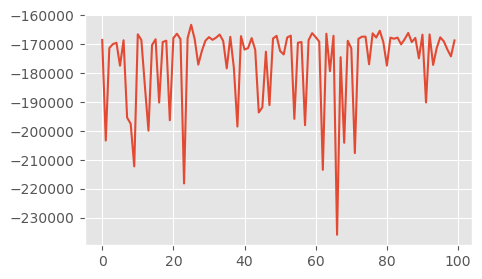

In [87]:
scores = regr_result.cv_results_['mean_test_score']
plt.plot(range(0,len(scores)), scores)

As expected with random search there is no clear pattern, hyperparameters are explored randomly

## Successive Halving

In [88]:
def regression_tree_successive_halving(X_train, X_test, y_train, y_test):
    search_space = {
        'max_depth': np.arange(max_depth_lower, max_depth_upper),
        'min_samples_split': np.arange(min_samples_split_lower, min_samples_split_upper, step = 5)
    }

    regr_default = DecisionTreeRegressor(random_state= rand_state)

    regr_hpo = HalvingGridSearchCV(
        regr_default,
        search_space,
        scoring='neg_mean_squared_error',
        cv=inner_eval,
        factor=1.5,
        min_resources='exhaust',
        max_resources='auto',
        random_state= rand_state,
        verbose=0,
        n_jobs=-1
    )

    regr_hpo.fit(X_train, y_train)
    predictions_y_test = regr_hpo.predict(X_test)

    print("Best parameters:", regr_hpo.best_params_)
    return regr_hpo, predictions_y_test

In [89]:
t0 = time.time()
regr_result, predictions = regression_tree_successive_halving(X_train, X_test, y_train, y_test)
running_time_halving_search = round(time.time()-t0,2)

best_score_halving_search = regr_result.best_score_
print(best_score_halving_search)

Best parameters: {'max_depth': 7, 'min_samples_split': 70}
-166653.18995667674


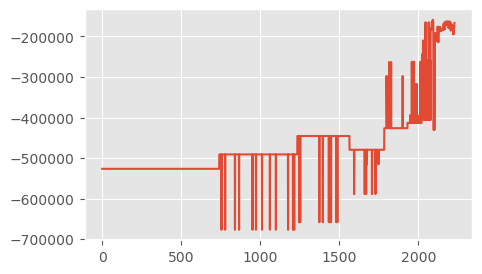

In [90]:
scores = regr_result.cv_results_['mean_test_score']
plt.plot(range(0,len(scores)), scores)

## Comparison

In [91]:
hpo_methods = ['Skopt Bayes', 'Optuna', 'Random Search', 'Successive Halving']
execution_times = [running_time_skopt, running_time_optuna, running_time_random_search, running_time_halving_search]
best_scores = [best_score_skopt, best_score_optuna, best_score_random_search, best_score_halving_search]
best_scores = [round(x/1000,2) for x in best_scores]

results = pd.DataFrame({'HPO method': hpo_methods, 'Best score': best_scores, 'Execution time': execution_times}).set_index('HPO method').T
results

HPO method,Skopt Bayes,Optuna,Random Search,Successive Halving
Best score,-165.93,-163.26,-163.29,-166.65
Execution time,276.69,210.28,27.53,18.51


While both the Bayes Optimization and Optuna show rather long execution times, only Optuna seemed to find the optimal parameters.

Surprisingly, Random Search achieves almost the same result while only taking a fraction of the time. This result also seemed to be very robust: we observed the same - or at least very similar - results with different parameters (other models/features used, lower/higher budgets). As execution time will take a bigger role for the more complex models, we decided to **continue with Random Search** instead of Optuna.

It is also noteworthy that Successive Halving shows the worst inner evaluation score. We were able to improve it slightly by tuning different parameters of the method, especially the split factor, however it was not possible to achieve a score similar to the other methods.

# Model Comparison

Now, as we decided on several factors using our basic Regression tree, finally we compare different ML models: Regression Tree, Gradient Boosted Regression Tree, Random Forest, and KNN.
All models will be built with and without HPO to see the effects HPO has on the different models.    

* Our comparison is based on the previously defined parameters:
  * Sotavento and edge stations data,
  * MICE-imputation,  
  * Random search as HPO

In [92]:
# define search space parameters
max_depth_lower = 2
max_depth_upper = 21
min_samples_split_lower = 10
min_samples_split_upper = 201

# budget
budg = 100

rand_state = 100510993

## Decision Tree

In [93]:
# no HPO
def regression_tree_no_HPO(X_train, X_test, y_train, y_test):
    regr_default = DecisionTreeRegressor(random_state=rand_state)
    regr_default.fit(X_train, y_train)
    predictions_y_test = regr_default.predict(X_test)

    mean_mse = cross_val_score(regr_default, X_train, y_train, cv=inner_eval, scoring='neg_mean_squared_error').mean()

    return regr_default, predictions_y_test, mean_mse

In [94]:
t0 = time.time()
regr_result, predictions, best_score = regression_tree_no_HPO(X_train, X_test, y_train, y_test)
running_time_decision_tree_no_hpo = round(time.time()-t0,2)

best_score_decision_tree_no_hpo = best_score

print(f'{best_score_decision_tree_no_hpo=}')
print(f'{running_time_decision_tree_no_hpo=}')

best_score_decision_tree_no_hpo=-271570.66527682764
running_time_decision_tree_no_hpo=7.27


In [95]:
# HPO (use model from HPO comparison)
t0 = time.time()
regr_result, predictions = regression_tree_random_search(X_train, X_test, y_train, y_test)
running_time_regression_tree_hpo = round(time.time()-t0,2)

best_score_regression_tree_hpo = regr_result.best_score_
print(f'{best_score_regression_tree_hpo=}')
print(f'{running_time_regression_tree_hpo=}')

Best parameters: {'min_samples_split': 85, 'max_depth': 6}
best_score_regression_tree_hpo=-163285.43429328373
running_time_regression_tree_hpo=27.64


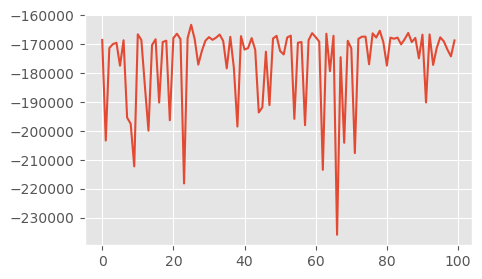

In [96]:
scores = regr_result.cv_results_['mean_test_score']
plt.plot(range(0,len(scores)), scores)

## Gradient Boosted Tree

In [97]:
# no HPO
def gradient_boosted_tree_no_HPO(X_train, X_test, y_train, y_test):
    hist_gb_reg = HistGradientBoostingRegressor(
      early_stopping=True,
      validation_fraction=0.1,
      n_iter_no_change=50,
      tol=0.01,
      random_state=rand_state
    )
    hist_gb_reg.fit(X_train, y_train)
    predictions_y_test = hist_gb_reg.predict(X_test)

    mean_mse = cross_val_score(hist_gb_reg, X_train, y_train, cv=inner_eval, scoring='neg_mean_squared_error').mean()

    return hist_gb_reg, predictions_y_test, mean_mse

In [98]:
t0 = time.time()
regr_result, predictions, best_score = gradient_boosted_tree_no_HPO(X_train, X_test, y_train, y_test)
running_time_gradient_boosted_tree_no_hpo = round(time.time()-t0,2)

best_score_gradient_boosted_tree_no_hpo = best_score

print(f'{best_score_gradient_boosted_tree_no_hpo=}')
print(f'{running_time_gradient_boosted_tree_no_hpo=}')

best_score_gradient_boosted_tree_no_hpo=-135745.83180616584
running_time_gradient_boosted_tree_no_hpo=13.4


In [99]:
def gradient_boosted_tree_HPO(X_train, X_test, y_train, y_test):
    search_space = {
      'learning_rate': (0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7),
      'min_samples_leaf': np.arange(5, 100, step = 10),
      'max_iter': np.arange(10, 300, step = 50),
      'max_depth': np.arange(max_depth_lower, max_depth_upper),
      'min_samples_leaf': np.arange(1, 100, step = 5)
    }

    hist_gb_reg = HistGradientBoostingRegressor(
      early_stopping=False,
      validation_fraction=0.1,
      n_iter_no_change=50,
      tol=0.01,
      random_state=rand_state
    )

    budget = budg
    regr_hpo = RandomizedSearchCV(
        hist_gb_reg,
        search_space,
        n_iter=budget,
        scoring='neg_mean_squared_error',
        cv=inner_eval,
        random_state= rand_state,
        verbose=0,
        n_jobs = -1
    )

    regr_hpo.fit(X_train, y_train)
    best_model = regr_hpo.best_estimator_
    predictions_y_test = best_model.predict(X_test)

    print("Best parameters:", regr_hpo.best_params_)
    return regr_hpo, predictions_y_test

In [100]:
t0 = time.time()
regr_result, predictions = gradient_boosted_tree_HPO(X_train, X_test, y_train, y_test)
running_time_gradient_boosted_tree_hpo  = round(time.time()-t0,2)

best_score_gradient_boosted_tree_hpo = regr_result.best_score_
print(f'{best_score_gradient_boosted_tree_hpo=}')
print(f'{running_time_gradient_boosted_tree_hpo=}')

Best parameters: {'min_samples_leaf': 66, 'max_iter': 260, 'max_depth': 13, 'learning_rate': 0.02}
best_score_gradient_boosted_tree_hpo=-132455.23746677197
running_time_gradient_boosted_tree_hpo=114.95


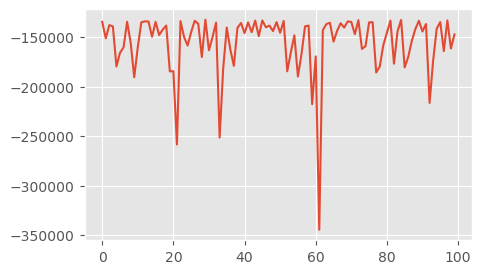

In [101]:
scores = regr_result.cv_results_['mean_test_score']
plt.plot(range(0,len(scores)), scores)

## Random Forest

In [102]:
def random_forest_no_HPO(X_train, X_test, y_train, y_test):
    regr_default = RandomForestRegressor(random_state= rand_state, n_jobs= -1)
    regr_default.fit(X_train, y_train)
    predictions_y_test = regr_default.predict(X_test)

    mean_mse = cross_val_score(regr_default, X_train, y_train, cv=inner_eval, scoring='neg_mean_squared_error').mean()

    return regr_default, predictions_y_test, mean_mse

In [103]:
t0 = time.time()
regr_result, predictions, best_score = random_forest_no_HPO(X_train, X_test, y_train, y_test)
running_time_random_forest_no_HPO = round(time.time()-t0,2)

best_score_random_forest_no_HPO = best_score

print(f'{best_score_random_forest_no_HPO=}')
print(f'{running_time_random_forest_no_HPO=}')

best_score_random_forest_no_HPO=-137179.77983483352
running_time_random_forest_no_HPO=59.91


In [104]:
def random_forest_HPO(X_train, X_test, y_train, y_test):
    search_space = {
        'max_depth': np.arange(max_depth_lower,max_depth_upper),
        'min_samples_split': np.arange(min_samples_split_lower,min_samples_split_upper,step=5),
        'n_estimators': np.arange(50,500,50),
        'max_features': np.arange(2,27,2)
      }

    regr_default = RandomForestRegressor(random_state= rand_state, n_jobs= -1)

    budget = budg
    regr_hpo = RandomizedSearchCV(
        regr_default,
        search_space,
        n_iter=budget,
        scoring='neg_mean_squared_error',
        cv=inner_eval,
        random_state= rand_state,
        verbose=0,
        n_jobs = -1
    )

    regr_hpo.fit(X_train, y_train)
    best_model = regr_hpo.best_estimator_
    predictions_y_test = best_model.predict(X_test)

    print("Best parameters:", regr_hpo.best_params_)
    return regr_hpo, predictions_y_test

In [105]:
t0 = time.time()
regr_result, predictions = random_forest_HPO(X_train, X_test, y_train, y_test)
running_time_random_forest_HPO  = round(time.time()-t0,2)

best_score_random_forest_HPO = regr_result.best_score_
print(f'{best_score_random_forest_HPO=}')
print(f'{running_time_random_forest_HPO=}')

Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 18, 'max_depth': 14}
best_score_random_forest_HPO=-135077.7358120305
running_time_random_forest_HPO=552.74


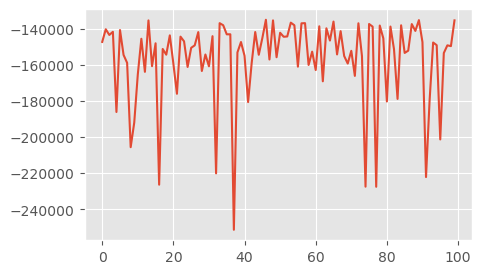

In [106]:
scores = regr_result.cv_results_['mean_test_score']
plt.plot(range(0,len(scores)), scores)

## KNN

For KNN it is important to standardize the data first.

In [107]:
scaler = StandardScaler()

X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

In [108]:
def knn_no_HPO(X_train, X_test, y_train, y_test):
    regr_default = KNeighborsRegressor()

    regr_default.fit(X_train, y_train)
    predictions_y_test = regr_default.predict(X_test)
    mean_mse = cross_val_score(regr_default, X_train, y_train, cv=inner_eval, scoring='neg_mean_squared_error').mean()

    return regr_default, predictions_y_test, mean_mse

In [109]:
t0 = time.time()
regr_result, predictions, best_score = knn_no_HPO(X_train_standardized, X_test_standardized, y_train, y_test)
running_time_knn_no_HPO = round(time.time()-t0,2)

best_score_knn_no_HPO = best_score

print(f'{best_score_knn_no_HPO=}')
print(f'{running_time_knn_no_HPO=}')

best_score_knn_no_HPO=-192796.90309431605
running_time_knn_no_HPO=0.91


In [110]:
def knn_HPO(X_train, X_test, y_train, y_test):
    search_space = {
        'n_neighbors': np.arange(1, 51, 2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    }

    regr_default = KNeighborsRegressor()

    budget = budg
    regr_hpo = RandomizedSearchCV(
        regr_default,
        search_space,
        n_iter=budget,
        scoring='neg_mean_squared_error',
        cv=inner_eval,
        random_state= rand_state,
        verbose=0,
        n_jobs = -1
    )

    regr_hpo.fit(X_train, y_train)
    best_model = regr_hpo.best_estimator_
    predictions_y_test = best_model.predict(X_test)

    print("Best parameters:", regr_hpo.best_params_)
    return regr_hpo, predictions_y_test

In [111]:
warnings.filterwarnings("ignore")
t0 = time.time()
regr_result, predictions = knn_HPO(X_train_standardized, X_test_standardized, y_train, y_test)
running_time_knn_HPO  = round(time.time()-t0,2)

best_score_knn_HPO = regr_result.best_score_
print(f'{best_score_knn_HPO=}')
print(f'{running_time_knn_HPO=}')

warnings.filterwarnings("default")

Best parameters: {'weights': 'distance', 'n_neighbors': 21, 'metric': 'manhattan'}
best_score_knn_HPO=-166296.8330858163
running_time_knn_HPO=12.49


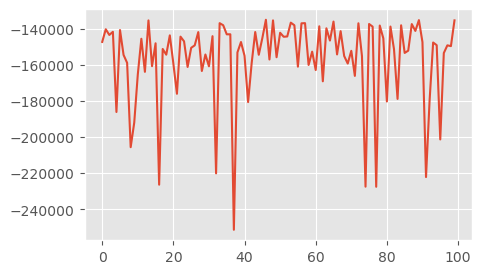

In [112]:
plt.plot(range(0,len(scores)),scores)

## Comparison

In [113]:
models = ['Decision Tree', 'Decision Tree HPO', 'Gradient Boosted Tree', 'Gradient Boosted Tree HPO',
          'Random Forest', 'Random Forest HPO', 'KNN', 'KNN HPO']

execution_times = [running_time_decision_tree_no_hpo, running_time_regression_tree_hpo, running_time_gradient_boosted_tree_no_hpo,
                   running_time_gradient_boosted_tree_hpo, running_time_random_forest_no_HPO, running_time_random_forest_HPO,
                   running_time_knn_no_HPO, running_time_knn_HPO]

best_scores = [best_score_decision_tree_no_hpo, best_score_regression_tree_hpo, best_score_gradient_boosted_tree_no_hpo,
 best_score_gradient_boosted_tree_hpo, best_score_random_forest_no_HPO, best_score_random_forest_HPO,
 best_score_knn_no_HPO, best_score_knn_HPO]

best_scores = [round(x/1000,2) for x in best_scores]


results = pd.DataFrame({'Model': models, 'Best score': best_scores, 'Execution time': execution_times}).set_index('Model').T
results

Model,Decision Tree,Decision Tree HPO,Gradient Boosted Tree,Gradient Boosted Tree HPO,Random Forest,Random Forest HPO,KNN,KNN HPO
Best score,-271.57,-163.29,-135.75,-132.46,-137.18,-135.08,-192.80,-166.30
Execution time,7.27,27.64,13.40,114.95,59.91,552.74,0.91,12.49



**Which method is more appropriate to the problem?**

According to the results of our inner evaluation, overall, **Gradient Boosted Tree using HPO** performs the best. This was also aligned with our initial assumption since Gradient Boosted trees are able to handle non linear relationships, which fit the time series data based on their sesonality and trends.
Also, Gradient boosted trees are more robust to irrelevant features as discussed during the class.
Furthermore, it should be more suitable for a larger dataset and for datapoints collected over long time peroids than other methods.

The random forest was able to achieve results similar to the ones from the gradient boosted tree. Overall, however, it performs a little worse while also taking significantly longer to run. While all models (aside from KNN) are based on trees, the Random Forest likely constructs the highest number of trees. As all the features are numerical, the computation of entropy (or gini) is very expensive. This could be one of the reasons why the Random Forest (especially with HPO) takes (by far) the longest to run.

The simple decision/regression tree shows significantly lower metrics (however, it benefitted the most from HPO). KNN worked better than the base tree, however, it did not benefit as much from HPO. KNN might be too sensitive to noise and irrelevant attributes for the problem at hand.
Overall, the results show that the more simple model can not comprehend the high complexity of the dataset.

**Does hyper-parameter tuning contribute to improve performance?**

Among all the models we have compared, HPO is not a huge factor and we believe that since our data is time-series, and it varies in time and seasonality a single fixed set of parameters cannot capture the evolving dynamics.
It is noteworthy that both the gradient boosted tree as well as the random forest and the KNN model show only a minor improvement in the inner evaulation score between the HPO and non-HPO models. At the same time the simple regression tree benefits a lot from HPO. Overall, however, HPO improves the performance of all models, as was expected.


**At what cost (compute time)**

Overall, as could be expected, using HPO extends the executiom time by a multiple. This is most noticable for the longest running model, the Random Forest, which does make sense while using Random Search as HPO as it multiplies the amount of time required to train a single model by the number of parameter combinations being tested. 
However, relatively speaking, the KNN model has the highest extension of execution time while also not benefitting too much from HPO in terms of the inner evalaution.


The SARIMA model above does not have stellar perormance as it is almost as bad as our dummy model. However as this was only something new to be explored, we did not spend much time to tune the model rather than focused on understanding how a time-series prone model would funcion.

Main takeway for us is that the model bases its fitting and evaluation on the type of data whether it is stationary or not, whether it has seasonality or not as well.

# Final Model

As explained earlier we use **Gradient Boosted Tree with HPO** as our final model.

## Estimation of Future Performance

In the following we compute the estimation of future performance of our final model. As we compute it using only the training partition and later on train the model with the complete dataset, it should be considered a pesimistic estimation.

In [115]:
regr_result, predictions = gradient_boosted_tree_HPO(X_train, X_test, y_train, y_test)

MSE = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mean_squared_error(y_test, predictions))
MAE = mean_absolute_error(y_test, predictions)

print(f'{MSE=}')
print(f'{RMSE=}')
print(f'{MAE=}')

Best parameters: {'min_samples_leaf': 66, 'max_iter': 260, 'max_depth': 13, 'learning_rate': 0.02}
MSE=143980.30698127786
RMSE=379.44737050252155
MAE=278.7214159087038


By our outer evaluation using the 2009 data as test data, a MSE of ~144000 and a MAE of ~278 was calculated. Therefore, when predicting future data, for each instance, we expect our model to have an average error of around 278 units.

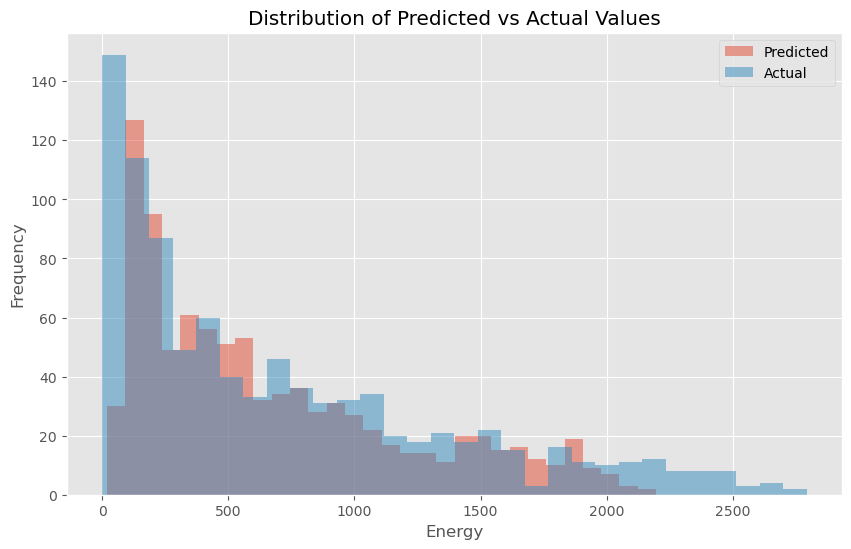

In [116]:
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=30, alpha=0.5, label='Predicted')
plt.hist(y_test, bins=30, alpha=0.5, label='Actual')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted vs Actual Values')
plt.legend()
plt.show()

From the histogram, it can be observed that there are quite a lot of instances in the testing data where the actual energy production was very low, whereas the model predicted many of these incorrectly. The same applies to instances with very high energy production. Overall, it can be observed that the model tends to predict worse for extreme instances (very low and very high energy production).

In [117]:
sum(predictions)/sum(y_test)

0.9713902386886721

It is also noteworthy that the predictions are a little conservative as the overall predicted enery production is lower than the actual one.

## Dummy comparison

In [118]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_predictions = dummy_regr.predict(X_test)

MSE_dummy = mean_squared_error(y_test, dummy_predictions)
RMSE_dummy = np.sqrt(mean_squared_error(y_test, dummy_predictions))
MAE_dummy = mean_absolute_error(y_test, dummy_predictions)

print(f'{MSE_dummy=}')
print(f'{RMSE_dummy=}')
print(f'{MAE_dummy=}')

MSE_dummy=444570.4489897425
RMSE_dummy=666.7611633784188
MAE_dummy=542.7629075881495


In [119]:
print(f'{MSE=}')
print(f'{RMSE=}')
print(f'{MAE=}')

MSE=143980.30698127786
RMSE=379.44737050252155
MAE=278.7214159087038


As expected, our final model performs much better than a dummy model predicting the mean.

## Prediction on Competition Data

In [120]:
df_competition = pd.read_csv('wind_competition.csv.gzip', compression='gzip')

In [121]:
df_competition.head(2)

,year,month,day,hour,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,p54.162.6,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
0,2010,1,1,0,2.403131e+06,2.395445e+06,2.387755e+06,2.380065e+06,2.372380e+06,2.399548e+06,...,7.212586,7.057422,6.90176,NaN,6.591434,7.184147,7.03098,6.877313,6.723647,6.570479
1,2010,1,1,6,2.410306e+06,2.402394e+06,NaN,2.386571e+06,2.378660e+06,NaN,...,0.207289,0.583972,NaN,NaN,1.714518,0.345988,0.72317,1.100850,1.478031,1.855712


In [122]:
# Sotavento + edge stations
stations = [1,5,13,21,25]
columns_to_keep = []

for col in df_competition.columns:
    if any(col.endswith(f'.{station}') for station in stations):
        columns_to_keep.append(col)

df_edge_stations_competition = df_competition.iloc[:, :4].copy()
df_edge_stations_competition = pd.concat([df_edge_stations_competition, df_competition[columns_to_keep]], axis=1)

df_edge_stations_competition.head(2)

,year,month,day,hour,p54.162.1,p54.162.5,p54.162.13,p54.162.21,p54.162.25,p55.162.1,...,u100.1,u100.5,u100.13,u100.21,u100.25,v100.1,v100.5,v100.13,v100.21,v100.25
0,2010,1,1,0,2.403131e+06,2.372380e+06,2.380345e+06,NaN,2.357261e+06,11.143643,...,3.113314,3.597732,3.028044,2.911909,3.052631,6.826923,NaN,6.801977,7.184147,6.570479
1,2010,1,1,6,2.410306e+06,2.378660e+06,2.387186e+06,2.399033e+06,2.363781e+06,11.163968,...,NaN,1.702957,1.905932,2.449463,1.842110,-0.315077,1.164212,0.819461,0.345988,1.855712


Now for our final model, we consider all available data instead of only the training partition. Our new "test partition" is now the competition data.

In [127]:
# using all data, Impute with MICE
train_all = pd.DataFrame(IterativeImputer(max_iter=50, random_state= rand_state).fit_transform(df_edge_stations),
                                       columns=df_edge_stations.columns,
                                       index=df_edge_stations.index)

X_test_all = pd.DataFrame(IterativeImputer(max_iter=50, random_state= rand_state).fit_transform(df_edge_stations_competition),
                                       columns=df_edge_stations_competition.columns,
                                       index=df_edge_stations_competition.index)

X_train_all = train_all.drop('energy', axis=1)
y_train_all = train_all['energy']

C:\Users\morit\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\morit\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Finally, we train our **final model** with the whole dataset and do hyperparameter tuning again.

In [128]:
# Final Model
final_model, predictions = gradient_boosted_tree_HPO(X_train_all, X_test_all, y_train_all, 'y_test')

Best parameters: {'min_samples_leaf': 66, 'max_iter': 260, 'max_depth': 16, 'learning_rate': 0.02}


In [130]:
predictions[:20]

array([ 669.98205523,  168.62627114,  783.35181116,  517.35534918,
        404.63790711,  358.46268006,  801.80534141, 1298.30282686,
       1594.72502267, 1055.19121192,  632.07766643,  157.15556898,
        315.83180447, 1048.4766671 ,  829.99600225, 1258.79323361,
       1008.67157245,  514.07867638,  110.54365967,   91.52792446])

In [131]:
# save final model
joblib.dump(final_model, 'final_model.pkl')

# save predicitions
df_predictions = pd.DataFrame({'Prediction': predictions})
df_predictions.to_csv('predictions_competition.txt', index=False)

# Conclusions and Insights
After a comprehensive analysis and model building, our final model, the Gradient Boosted Tree with HPO, has a relatively good performance with an RMSE of aproximately 378.82 justifying its ability to capture complex patterns in the data, despite the relatively higher computation time. As expected, it performs better than a dummy model.

Overall to recap, our model is based on MICE imputation, takes into consideration only features related to Sotavento and edge stations, uses Random Seach for HPO in the inner evaluation. 

The best parameters based on the inner evaluation for our final model are a min_samples_leaf of 66, max_iter of 260 which is optimal since a bigger number could lead to overfitting as well as the max_depth of 16 meaning a tree cannot be deeper than that. The learning rate of 0.02 required more iterations but led to better performance.